# Credit Card Default Prediction - Logistic Regression using XGBoost
#### Steps:
1. Load the data (without normalisation)
2. Train a baseline model & evaluation
3. Hyperparameters tuning
4. Find optimal model & evaluation
5. Feature selection
<br>

#### Statistics of the optimal model:
1. **Accuracy score**: 0.796
2. **f1 score**: 0.529
3. **ROC AUC**: 0.703
4. **False Positive**: 646 cases, **False Negative**: 579 cases.
5. The top 3 features appeared most in a tree are PAY_AMT1, PAY_AMT2, PAY_AMT6. The feature has the highest average gain and coverage of splits is PAY_1. 
<br>The 3 features appeared leaest in a tree are PAY_5, PAY_6, PAY_4. The feature has the lowest average gain and coverage of splits is AgeBin.
<br>

#### Feature selection results:
- Selected features for **n = 3**: 'PAY_1', 'PAY_2', 'PAY_3'
- Selected features for **n = 5**: 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5'

#### Further research direction:
1. Decrease the amount of false positive and false negative cases.

In [ ]:
!pip install xgboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

import time

C:\Users\yange\Anaconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load train & test data

In [2]:
# load pre-processed (unnormalised) training & test set
path = '../data/' # change to your local file location

df_train = pd.read_csv(path + 'CreditCard_train_processed_unf.csv')
df_test = pd.read_csv(path + 'CreditCard_test_processed_unf.csv')

In [3]:
df_train

,LIMIT_BAL,EDUCATION,SEX_MAR,AgeBin,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAY_AMT5,PAY_AMT6,Closeness_1,Closeness_2,Closeness_3,Closeness_4,Closeness_5,Closeness_6,diff,default
0,20000,2,2,1,2,2,-1,-1,-2,-2,...,0,0,16087,16898,19311,20000,20000,20000,7015,1
1,120000,2,4,1,-1,2,-1,-1,-1,2,...,0,2000,117318,118275,117318,116728,116545,116739,12077,1
2,90000,2,4,2,-1,-1,-1,-1,-1,-1,...,1000,5000,60761,75973,76441,75669,75052,74451,90635,0
3,50000,2,2,2,-1,-1,-1,-1,-1,-1,...,1069,1000,3010,1767,709,21686,21041,20453,222946,0
4,50000,2,1,4,-1,-1,-1,-1,-1,-1,...,689,679,41383,44330,14165,29060,30854,30869,50290,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,80000,2,1,1,1,2,2,-1,-1,-1,...,2000,1830,-906,-2789,-903,-215,16704,30146,424045,0
23996,20000,2,1,1,-1,-1,-1,-1,-1,-1,...,500,1000,5553,4545,2438,2678,2881,2650,91519,0
23997,10000,2,2,1,-1,-1,-1,-1,-1,-1,...,1820,1000,1118,67,175,-7506,-6608,824,63990,0
23998,20000,4,2,1,-1,-1,-1,-1,-1,-2,...,0,0,-564,-284,606,-19950,20000,20000,93574,0


In [4]:
df_test

,LIMIT_BAL,EDUCATION,SEX_MAR,AgeBin,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAY_AMT5,PAY_AMT6,Closeness_1,Closeness_2,Closeness_3,Closeness_4,Closeness_5,Closeness_6,diff,default
0,50000,2,2,1,2,2,-1,-1,-1,-1,...,704,707,-1246,242,1544,5884,28753,29934,226811,0
1,60000,2,2,1,-1,-1,-1,-1,-1,-1,...,3000,1120,1928,960,2584,4264,33042,31153,273294,1
2,400000,2,2,1,-1,-1,-1,-1,-1,-1,...,510,959,384670,391374,388530,389255,379263,390455,59932,0
3,20000,4,2,1,5,4,3,2,2,2,...,0,0,-1673,-1051,-440,291,-113,160,121926,0
4,50000,3,2,1,-1,-1,-2,-2,-1,-1,...,200,100,17410,50100,50000,50000,49930,49880,32210,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,220000,3,1,2,-1,-1,-1,-1,-1,-1,...,5000,1000,31052,27185,11635,131996,188763,204020,682799,0
5996,150000,3,2,3,-1,-1,-1,-1,-1,-1,...,0,0,148317,148172,146498,141021,144810,150000,6692,0
5997,30000,2,2,2,4,3,2,-1,-1,-1,...,2000,3100,26435,26644,27242,9122,9418,10643,39196,1
5998,80000,3,1,3,1,-1,-1,-1,-1,-1,...,52964,1804,81645,1621,3696,27226,68145,31056,119430,1


In [5]:
# set up X and y variable matrices
Xtrain = df_train[['LIMIT_BAL', 'EDUCATION', 'SEX_MAR', 'AgeBin', 
                   'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
                   'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
                   'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
                   'Closeness_1', 'Closeness_2', 'Closeness_3', 'Closeness_4','Closeness_5', 'Closeness_6',
                   'diff']]
Xtest = df_test[['LIMIT_BAL', 'EDUCATION', 'SEX_MAR', 'AgeBin', 
                 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
                 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
                 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
                 'Closeness_1', 'Closeness_2', 'Closeness_3', 'Closeness_4','Closeness_5', 'Closeness_6',
                 'diff']]

ytrain = df_train['default']
ytest = df_test['default']

In [6]:
# set up validation set - 20%
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
print('Training set:', len(ytrain))
print('Validation set:', len(yval))
print('Test set:', len(ytest))

Training set: 18000
Validation set: 6000
Test set: 6000


Training : Validation : Test = **6:2:2**

## Model training

### Preparations: create DMatrix, write some helper functions

In [7]:
# create DMatrix
DTrain = xgb.DMatrix(Xtrain, label=ytrain)
DVal = xgb.DMatrix(Xval, label=yval)
DTest = xgb.DMatrix(Xtest, label=ytest)

In [69]:
# global variable
NUM_BOOST_ROUND = 1000

In [8]:
# gridsearch parameter set (for 2 parameters) using 5-fold cross validation with single evaluation metrix 'logloss'
def gridsearch_best_params(params_set, param1_name:str, param2_name:str, string_format, figwidth=10):
    # create a DataFrame to hold the results
    results = pd.DataFrame(columns=['params', 'test-logloss-mean', 'boost rounds'])
    
    for param1, param2 in params_set:
        print(string_format.format(param1, param2))
        # update parameters
        params[param1_name] = param1
        params[param2_name] = param2
        
        # run CV
        cv_results = xgb.cv(
            params,
            DTrain,
            num_boost_round=NUM_BOOST_ROUND, # set up a large iteration, will stop early
            seed=42,
            nfold=5,
            metrics={'logloss'}, # default choice for classification task
            early_stopping_rounds=10)
        
        # write down the results
        mean_logloss = cv_results['test-logloss-mean'].min()
        boost_rounds = cv_results['test-logloss-mean'].argmin()
        results = results.append({'params':"({},{})".format(param1, param2), 'test-logloss-mean':mean_logloss, 'boost rounds':boost_rounds},
                                ignore_index=True)
    
    # visualise the results
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(figwidth,8))
    results.plot(x="params", y=["test-logloss-mean"], ax=ax[0], color='green')
    results.plot(x="params", y=["boost rounds"], ax=ax[1], x_compat=True)

    plt.setp(ax[0].get_xticklabels(), visible=False)
    plt.xticks(results.index, results['params']) 
    fig.suptitle("Gridsearch CV for parameters tuning: {}, {}".format(param1_name, param2_name), fontsize=14)
    plt.show()
    
    print(results)

In [9]:
# gridsearch parameter set (for single parameter) using 5-fold cross validation with single evaluation metrix 'logloss'
def gridsearch_best_param(param_set, param_name:str, string_format, figwidth=10, convert_to_str=False, timed=False):
    # create a DataFrame to hold the results
    results = pd.DataFrame(columns=['param', 'test-logloss-mean', 'boost rounds'])
    
    for param in param_set:
        print(string_format.format(param))
        # update parameters
        params[param_name] = param
        
        if timed:
            start = time.time()
        # run CV
        cv_results = xgb.cv(
            params,
            DTrain,
            num_boost_round=NUM_BOOST_ROUND,
            seed=42,
            nfold=5,
            metrics={'logloss'}, # default choice for classification task
            early_stopping_rounds=10)
        
        if timed:
            end = time.time()
            print ("Time used:", end - start)
        
        # write down the results
        mean_logloss = cv_results['test-logloss-mean'].min()
        boost_rounds = cv_results['test-logloss-mean'].argmin()
        results = results.append({'param':param, 'test-logloss-mean':mean_logloss, 'boost rounds':boost_rounds},
                                ignore_index=True)
    
    # visualise the results
    if convert_to_str:
        results['param'] = results['param'].astype(str)
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(figwidth,8))
    results.plot(x="param", y=["test-logloss-mean"], ax=ax[0], color='green')
    results.plot(x="param", y=["boost rounds"], ax=ax[1], x_compat=True)

    plt.setp(ax[0].get_xticklabels(), visible=False)
    plt.xticks(results.index, results['param'])
    fig.suptitle("Gridsearch CV for parameter tuning: {}".format(param_name), fontsize=14)
    plt.show()
    
    print(results)

### Baseline model:  hyperparameters with default values

In [12]:
params = {
    # parameters for tree booster with default values (to be tuned)
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': .3,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'alpha': 0,
    'lambda': 1,
    # other parameters
    'scale_pos_weight': 1.0,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss' # default for classification task
}

**Estimate the 'scale_pos_weight'** - an XGBoost build-in hyperparameter designed to tune the behavior of the algorithm for imbalanced classification problem

In [13]:
default_count = ytrain.sum()
nondefault_count = len(ytrain) - default_count
# update the recommended value for 'scale_pos_weight'
params['scale_pos_weight'] = nondefault_count / default_count

print('scale_pos_weight =', nondefault_count / default_count)

scale_pos_weight = 3.5180722891566263


In [15]:
# train the baseline model
xgb0 = xgb.train(
    params,
    DTrain,
    num_boost_round=NUM_BOOST_ROUND,
    evals=[(DVal, 'valid')],
    early_stopping_rounds=10
)

print("Lowest logloss for validation set: {} with {} rounds".format(xgb0.best_score, xgb0.best_iteration+1))

[0]	valid-logloss:0.62999
Will train until valid-logloss hasn't improved in 10 rounds.
[1]	valid-logloss:0.59412
[2]	valid-logloss:0.57369
[3]	valid-logloss:0.56138
[4]	valid-logloss:0.55283
[5]	valid-logloss:0.54749
[6]	valid-logloss:0.54380
[7]	valid-logloss:0.54095
[8]	valid-logloss:0.53852
[9]	valid-logloss:0.53658
[10]	valid-logloss:0.53595
[11]	valid-logloss:0.53543
[12]	valid-logloss:0.53415
[13]	valid-logloss:0.53383
[14]	valid-logloss:0.53317
[15]	valid-logloss:0.53341
[16]	valid-logloss:0.53314
[17]	valid-logloss:0.53287
[18]	valid-logloss:0.53285
[19]	valid-logloss:0.53227
[20]	valid-logloss:0.53223
[21]	valid-logloss:0.53166
[22]	valid-logloss:0.53191
[23]	valid-logloss:0.53170
[24]	valid-logloss:0.53068
[25]	valid-logloss:0.53087
[26]	valid-logloss:0.53082
[27]	valid-logloss:0.53060
[28]	valid-logloss:0.52998
[29]	valid-logloss:0.52963
[30]	valid-logloss:0.52965
[31]	valid-logloss:0.52953
[32]	valid-logloss:0.52939
[33]	valid-logloss:0.52893
[34]	valid-logloss:0.52864
[35]

In [16]:
predictions = [int(round(value)) for value in xgb0.predict(DTest)]

In [17]:
# evaluation - scores
print('accuracy score:', accuracy_score(y_true = ytest, y_pred = predictions))
print('f1 score:', f1_score(y_true = ytest, y_pred = predictions))
print('ROC AUC:', roc_auc_score(y_true = ytest, y_score = predictions))

accuracy score: 0.7828333333333334
f1 score: 0.5218348623853211
ROC AUC: 0.7018027298738378


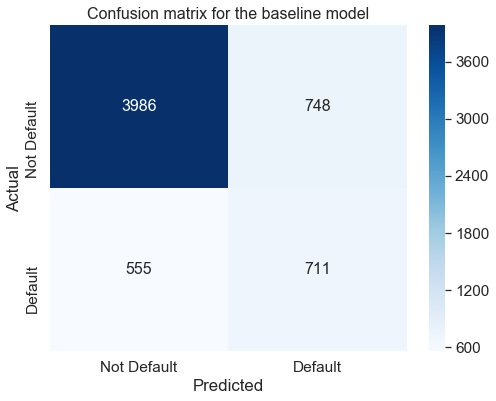

In [18]:
# evaluation - confusion matrix
xgb0_cm = pd.DataFrame(confusion_matrix(ytest, predictions), 
                       columns=['Not Default', 'Default'], index = ['Not Default', 'Default'])
xgb0_cm.index.name = 'Actual'
xgb0_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,6))
sns.set(font_scale=1.4) # label size
sns.heatmap(xgb0_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 16}) # integer format, font size 16
plt.title('Confusion matrix for the baseline model', fontsize=16)
plt.show()

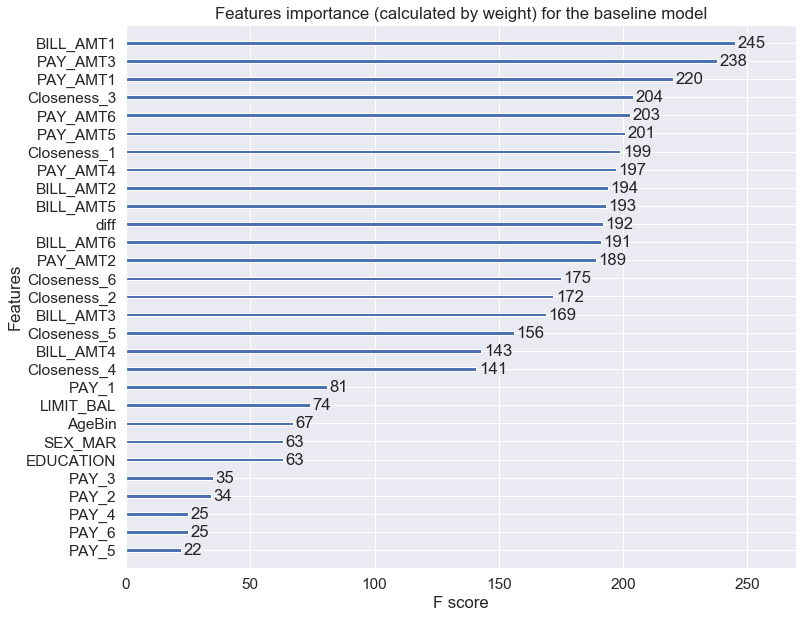

In [19]:
# features importance - by weight
fig, ax = plt.subplots(1,1,figsize=(12,10))
xgb.plot_importance(xgb0, importance_type='weight', ax=ax)
plt.title('Features importance (calculated by weight) for the baseline model')
plt.show()

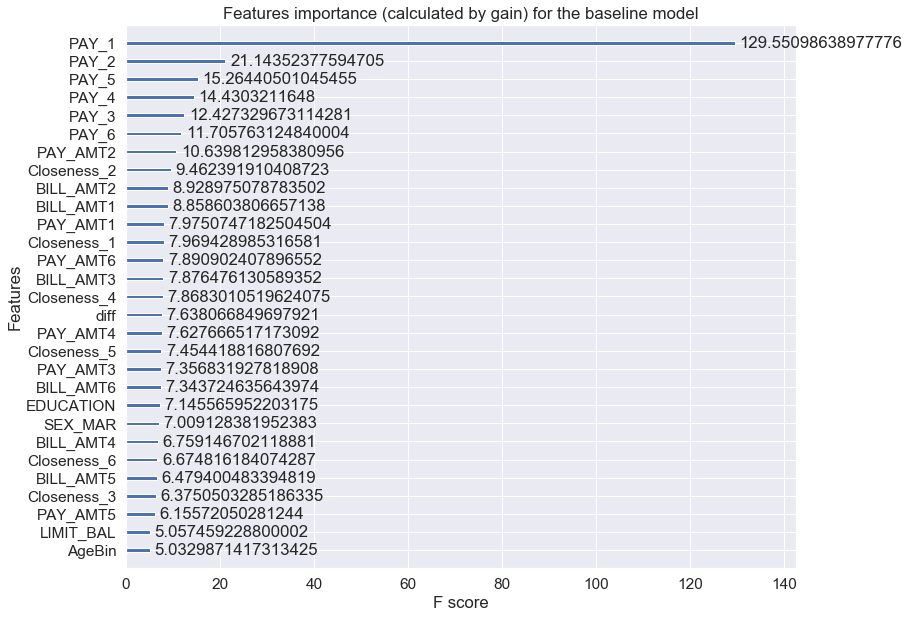

In [20]:
# features importance - by gain
fig, ax = plt.subplots(1,1,figsize=(12,10))
xgb.plot_importance(xgb0, importance_type='gain', ax=ax)
plt.title('Features importance (calculated by gain) for the baseline model')
plt.show()

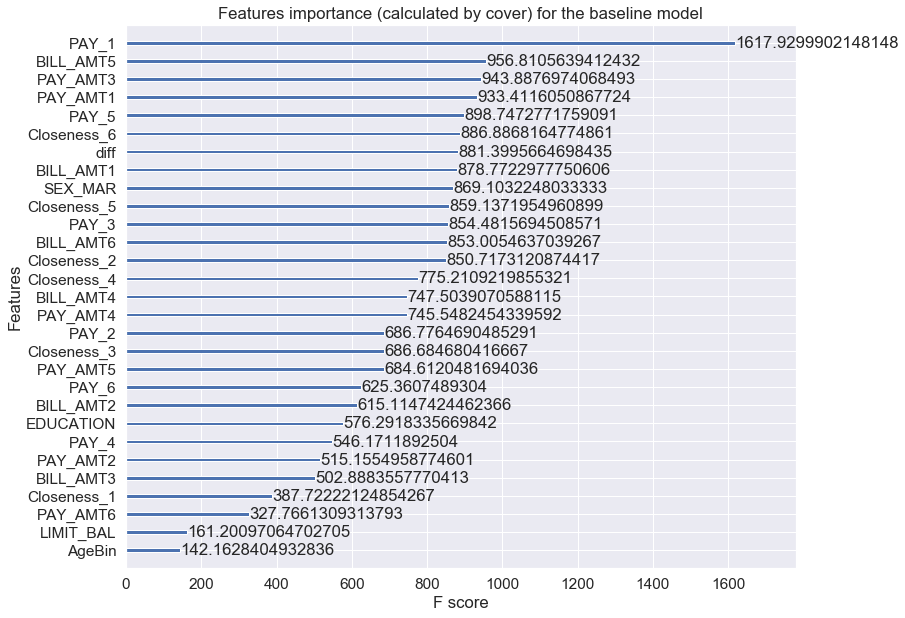

In [21]:
# features importance - by cover
fig, ax = plt.subplots(1,1,figsize=(12,10))
xgb.plot_importance(xgb0, importance_type='cover', ax=ax)
plt.title('Features importance (calculated by cover) for the baseline model')
plt.show()

Summary of the statistics of the baseline model:
1. **Accuracy score**: 0.783
2. **f1 score**: 0.522
3. **ROC AUC**: 0.702
4. **False Positive**: 748 cases, **False Negative**: 555 cases.
5. The top 3 features appeared most in a tree are BILL_AMT1, PAY_AMT3, PAY_AMT1. The feature has the highest average gain and coverage of splits is PAY_1. 
<br>The 3 features appeared leaest in a tree are PAY_5, PAY_6, PAY_4. The feature has the lowest average gain and coverage of splits is AgeBin.

### Parameters Tuning

#### Step 1: Tune max_depth and min_child_weight

CV with max_depth=3, min_child_weight=1
CV with max_depth=3, min_child_weight=3
CV with max_depth=3, min_child_weight=5
CV with max_depth=5, min_child_weight=1
CV with max_depth=5, min_child_weight=3
CV with max_depth=5, min_child_weight=5
CV with max_depth=7, min_child_weight=1
CV with max_depth=7, min_child_weight=3
CV with max_depth=7, min_child_weight=5
CV with max_depth=9, min_child_weight=1
CV with max_depth=9, min_child_weight=3
CV with max_depth=9, min_child_weight=5


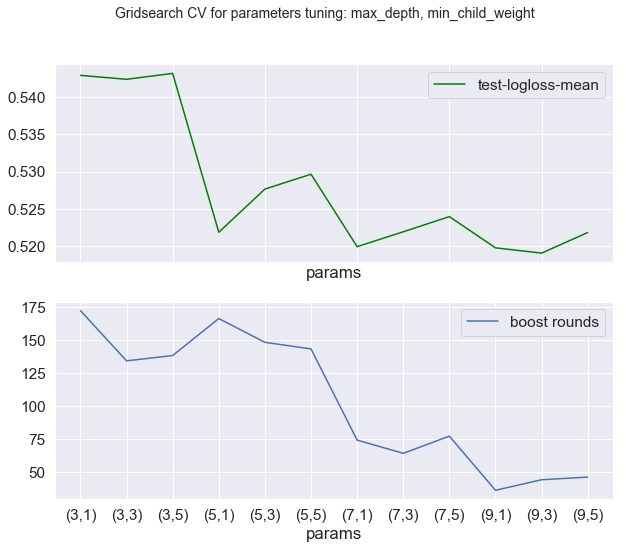

   params  test-logloss-mean boost rounds
0   (3,1)           0.542919          172
1   (3,3)           0.542392          134
2   (3,5)           0.543183          138
3   (5,1)           0.521846          166
4   (5,3)           0.527645          148
5   (5,5)           0.529638          143
6   (7,1)           0.519908           74
7   (7,3)           0.521909           64
8   (7,5)           0.523945           77
9   (9,1)           0.519754           36
10  (9,3)           0.519044           44
11  (9,5)           0.521810           46


In [49]:
# perform GridSearch on testing 12 combinations
param_test1 = [(max_depth, min_child_weight)
              for max_depth in range(3,10,2)
              for min_child_weight in range(1,6,2)]

gridsearch_best_params(param_test1, 'max_depth', 'min_child_weight', "CV with max_depth={}, min_child_weight={}")

Choose (9,3) which has the lowest test-logloss-mean and a low boost rounds. This can be considered as the optimal.
<br>
Need to check optimal value in step 1.

CV with max_depth=8, min_child_weight=2
CV with max_depth=8, min_child_weight=3
CV with max_depth=8, min_child_weight=4
CV with max_depth=9, min_child_weight=2
CV with max_depth=9, min_child_weight=3
CV with max_depth=9, min_child_weight=4
CV with max_depth=10, min_child_weight=2
CV with max_depth=10, min_child_weight=3
CV with max_depth=10, min_child_weight=4


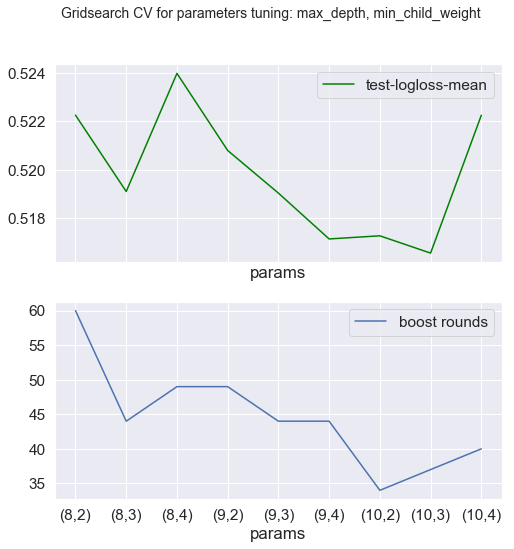

   params  test-logloss-mean boost rounds
0   (8,2)           0.522252           60
1   (8,3)           0.519111           44
2   (8,4)           0.523971           49
3   (9,2)           0.520799           49
4   (9,3)           0.519044           44
5   (9,4)           0.517158           44
6  (10,2)           0.517287           34
7  (10,3)           0.516575           37
8  (10,4)           0.522247           40


In [50]:
# test values in step 1, centred at (9,3)
param_test1b = [(max_depth, min_child_weight)
              for max_depth in [8,9,10]
              for min_child_weight in [2,3,4]]

gridsearch_best_params(param_test1b, 'max_depth', 'min_child_weight', "CV with max_depth={}, min_child_weight={}", 8)

(10,3) is the optimal one.

In [22]:
# update optimal parameter values
params['max_depth'] = 10
params['min_child_weight'] = 3

#### Step 2: Tune subsamples and colsample_bytree

CV with subsample=0.7, colsample_bytree=0.7
CV with subsample=0.7, colsample_bytree=0.8
CV with subsample=0.7, colsample_bytree=0.9
CV with subsample=0.7, colsample_bytree=1.0
CV with subsample=0.8, colsample_bytree=0.7
CV with subsample=0.8, colsample_bytree=0.8
CV with subsample=0.8, colsample_bytree=0.9
CV with subsample=0.8, colsample_bytree=1.0
CV with subsample=0.9, colsample_bytree=0.7
CV with subsample=0.9, colsample_bytree=0.8
CV with subsample=0.9, colsample_bytree=0.9
CV with subsample=0.9, colsample_bytree=1.0
CV with subsample=1.0, colsample_bytree=0.7
CV with subsample=1.0, colsample_bytree=0.8
CV with subsample=1.0, colsample_bytree=0.9
CV with subsample=1.0, colsample_bytree=1.0


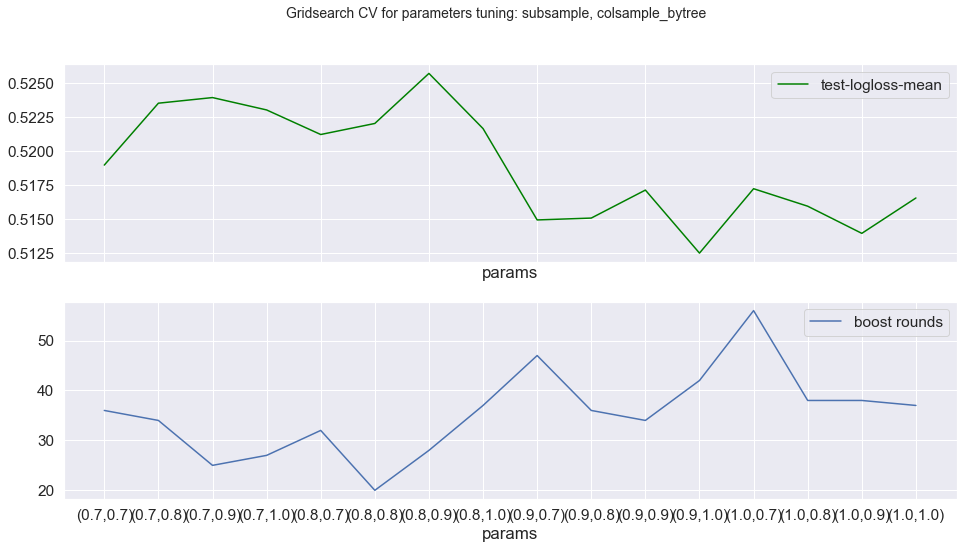

       params  test-logloss-mean boost rounds
0   (0.7,0.7)           0.518990           36
1   (0.7,0.8)           0.523536           34
2   (0.7,0.9)           0.523948           25
3   (0.7,1.0)           0.523040           27
4   (0.8,0.7)           0.521236           32
5   (0.8,0.8)           0.522047           20
6   (0.8,0.9)           0.525723           28
7   (0.8,1.0)           0.521671           37
8   (0.9,0.7)           0.514963           47
9   (0.9,0.8)           0.515100           36
10  (0.9,0.9)           0.517155           34
11  (0.9,1.0)           0.512527           42
12  (1.0,0.7)           0.517255           56
13  (1.0,0.8)           0.515971           38
14  (1.0,0.9)           0.513978           38
15  (1.0,1.0)           0.516575           37


In [52]:
# perform GridSearch on testing 16 combinations
param_test2 = [(subsample, colsample)
              for subsample in [i/10 for i in range(7,11)]
              for colsample in [i/10 for i in range(7,11)]]

gridsearch_best_params(param_test2, 'subsample', 'colsample_bytree', "CV with subsample={}, colsample_bytree={}", 16)

(0.9,1.0) has the lowest test-logloss-mean and a relatively low boost rounds. This can be considered as the optimal.
<br>
Need to check optimal value in step 0.05.

CV with subsample=0.85, colsample_bytree=0.95
CV with subsample=0.85, colsample_bytree=1.0
CV with subsample=0.9, colsample_bytree=0.95
CV with subsample=0.9, colsample_bytree=1.0
CV with subsample=0.95, colsample_bytree=0.95
CV with subsample=0.95, colsample_bytree=1.0


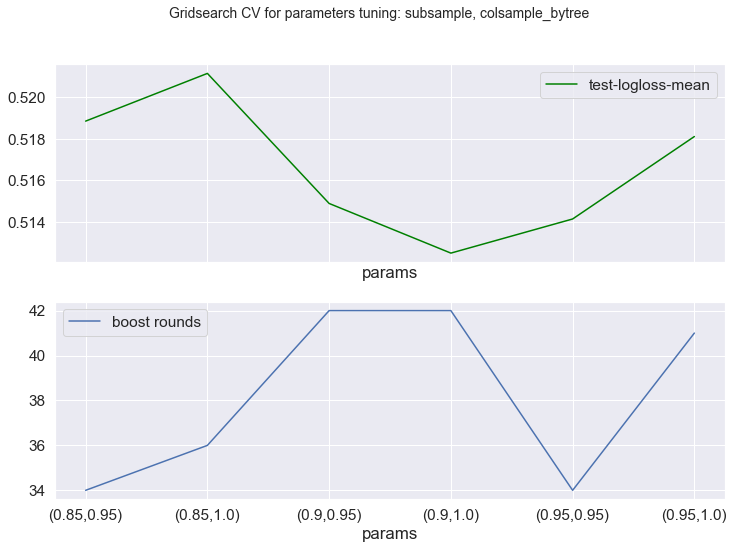

        params  test-logloss-mean boost rounds
0  (0.85,0.95)           0.518838           34
1   (0.85,1.0)           0.521120           36
2   (0.9,0.95)           0.514901           42
3    (0.9,1.0)           0.512527           42
4  (0.95,0.95)           0.514159           34
5   (0.95,1.0)           0.518101           41


In [54]:
# test values in step 0.05, centred at (0.9,1.0)
# note that 1.0 is the maximum value for 'subsample' and 'colsample_bytree'
param_test2b = [(subsample, colsample)
              for subsample in [i/100 for i in range(85,100,5)]
              for colsample in [i/100 for i in range(95,105,5)]]

gridsearch_best_params(param_test2b, 'subsample', 'colsample_bytree', "CV with subsample={}, colsample_bytree={}", 12)

(0.9,1.0) is still the optimal one for test-logloss-mean, though it needs a high boost rounds.

In [23]:
# update optimal parameter values
params['subsample'] = 0.9
params['colsample_bytree'] = 1.0

#### Step 3: Tune gamma

CV with gamma=0
CV with gamma=1
CV with gamma=2
CV with gamma=3
CV with gamma=4
CV with gamma=5
CV with gamma=6
CV with gamma=7
CV with gamma=8
CV with gamma=9
CV with gamma=10


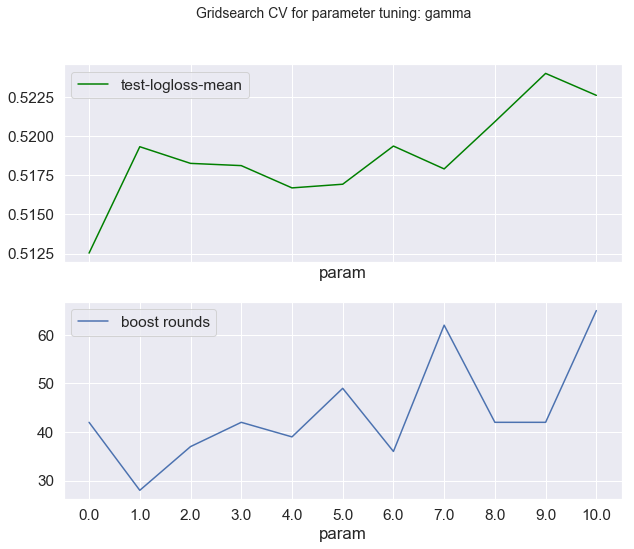

    param  test-logloss-mean  boost rounds
0     0.0           0.512527          42.0
1     1.0           0.519333          28.0
2     2.0           0.518267          37.0
3     3.0           0.518124          42.0
4     4.0           0.516698          39.0
5     5.0           0.516933          49.0
6     6.0           0.519374          36.0
7     7.0           0.517913          62.0
8     8.0           0.520932          42.0
9     9.0           0.524022          42.0
10   10.0           0.522619          65.0


In [56]:
# perform GridSearch on testing 11 values
param_test3 = [i for i in range(0,11)]

gridsearch_best_param(param_test3, 'gamma', "CV with gamma={}")

gamma = 0 has the lowest test-logloss-mean and a relatively low boost rounds. This can be considered as the optimal.
<br>
Need to check optimal value in step 0.1.

CV with gamma=0.0
CV with gamma=0.1
CV with gamma=0.2
CV with gamma=0.3
CV with gamma=0.4
CV with gamma=0.5
CV with gamma=0.6
CV with gamma=0.7
CV with gamma=0.8
CV with gamma=0.9
CV with gamma=1.0


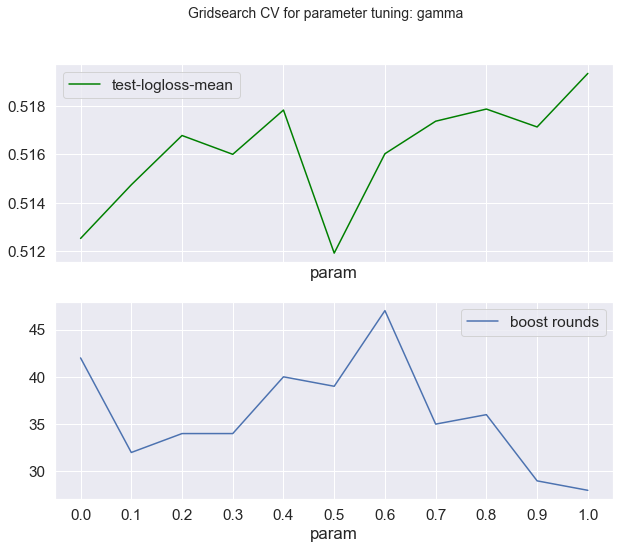

   param  test-logloss-mean  boost rounds
0    0.0           0.512527          42.0
1    0.1           0.514738          32.0
2    0.2           0.516772          34.0
3    0.3           0.515996          34.0
4    0.4           0.517822          40.0
5    0.5           0.511922          39.0
6    0.6           0.516020          47.0
7    0.7           0.517361          35.0
8    0.8           0.517863          36.0
9    0.9           0.517124          29.0
10   1.0           0.519333          28.0


In [58]:
# test values in step 0.1, centred at (0.0)
param_test3b = [i/10 for i in range(0,11)]

gridsearch_best_param(param_test3b, 'gamma', "CV with gamma={}", convert_to_str=True)

gamma = 0.5 is the optimal one.

In [24]:
# update optimal parameter value
params['gamma'] = 0.5

#### Step 4: Tune regularisation parameters - alpha, lambda

CV with alpha=1e-05
CV with alpha=0.0001
CV with alpha=0.001
CV with alpha=0.01
CV with alpha=0.1
CV with alpha=1
CV with alpha=10
CV with alpha=50
CV with alpha=100


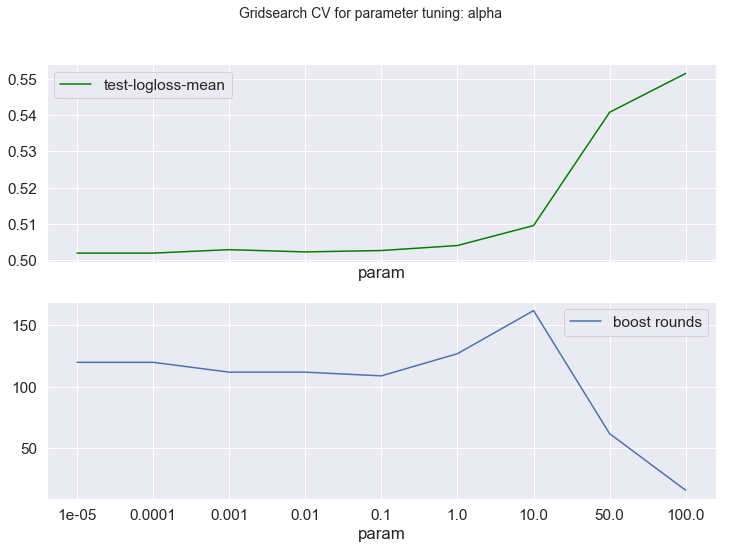

    param  test-logloss-mean  boost rounds
0   1e-05           0.501959         120.0
1  0.0001           0.501960         120.0
2   0.001           0.502909         112.0
3    0.01           0.502290         112.0
4     0.1           0.502669         109.0
5     1.0           0.504048         127.0
6    10.0           0.509548         162.0
7    50.0           0.540779          62.0
8   100.0           0.551475          16.0


In [63]:
# select 9 values from a broad range, perform GridSearch on testing these 9 values for 'alpha'
param_test4_alpha = [1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10, 50, 100]

gridsearch_best_param(param_test4_alpha, 'alpha', "CV with alpha={}", convert_to_str=True)

The lower the alpha, the lower the test-logloss-mean. Therefore, it'd better to keep alpha as its default value: 0.

In [25]:
# update optimal parameter value
params['alpha'] = 0     # the default value

CV with lambda=1e-05
CV with lambda=0.0001
CV with lambda=0.001
CV with lambda=0.01
CV with lambda=0.1
CV with lambda=1
CV with lambda=10
CV with lambda=50
CV with lambda=100


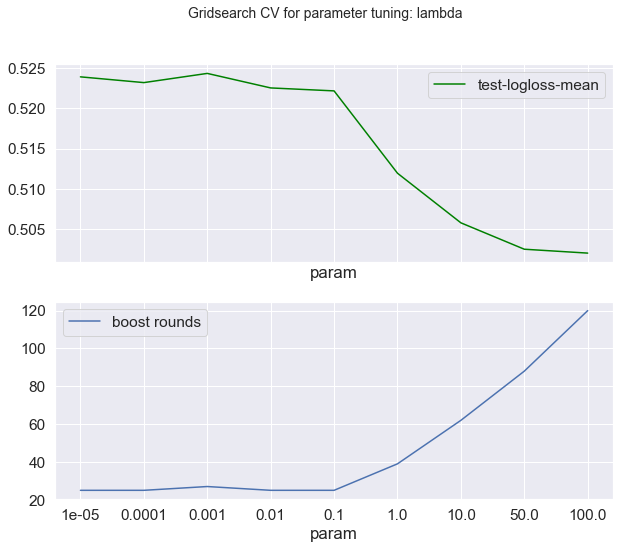

    param  test-logloss-mean  boost rounds
0   1e-05           0.523942          25.0
1  0.0001           0.523224          25.0
2   0.001           0.524372          27.0
3    0.01           0.522561          25.0
4     0.1           0.522191          25.0
5     1.0           0.511922          39.0
6    10.0           0.505735          62.0
7    50.0           0.502444          88.0
8   100.0           0.501960         120.0


In [23]:
# select 9 values from a broad range, perform GridSearch on testing 9 values for 'lambda'
param_test4_lambda = [1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10, 50, 100]

gridsearch_best_param(param_test4_lambda, 'lambda', "CV with lambda={}", convert_to_str=True)

The higher the lambda, the lower the test-logloss-mean. Take a closer look at values between 0.1 and 50. 

CV with lambda=0.1
CV with lambda=0.3
CV with lambda=0.6
CV with lambda=0.9
CV with lambda=1
CV with lambda=3
CV with lambda=6
CV with lambda=9
CV with lambda=10
CV with lambda=20
CV with lambda=30
CV with lambda=40
CV with lambda=50


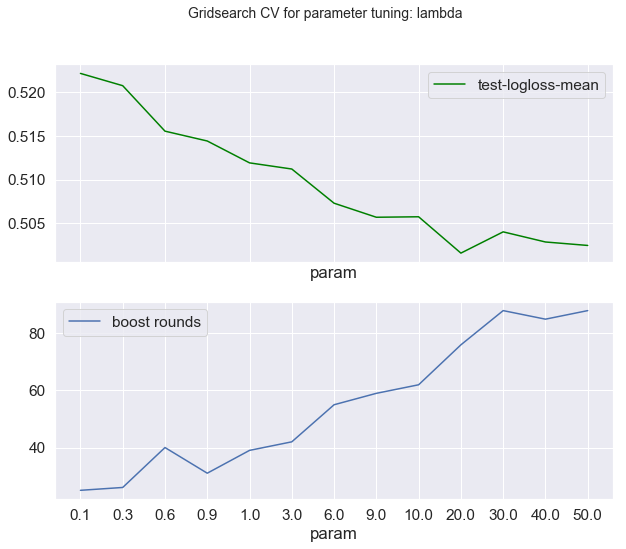

   param  test-logloss-mean  boost rounds
0    0.1           0.522191          25.0
1    0.3           0.520781          26.0
2    0.6           0.515562          40.0
3    0.9           0.514433          31.0
4    1.0           0.511922          39.0
5    3.0           0.511217          42.0
6    6.0           0.507293          55.0
7    9.0           0.505681          59.0
8   10.0           0.505735          62.0
9   20.0           0.501565          76.0
10  30.0           0.504004          88.0
11  40.0           0.502842          85.0
12  50.0           0.502444          88.0


In [24]:
# test values between 0.1 and 50
param_test4b_lambda = [0.1, 0.3, 0.6, 0.9, 1, 3, 6, 9, 10, 20, 30, 40, 50]

gridsearch_best_param(param_test4b_lambda, 'lambda', "CV with lambda={}", convert_to_str=True)

lambda = 20 has the lowest the test-logloss-mean. This is a relatively high lambda value, with the risk of underfitting the model. But let's consider it as the optimal at the moment.
<br>
Need to check values around 20 in a smaller step.

CV with lambda=15
CV with lambda=16
CV with lambda=17
CV with lambda=18
CV with lambda=19
CV with lambda=20
CV with lambda=21
CV with lambda=22
CV with lambda=23
CV with lambda=24
CV with lambda=25


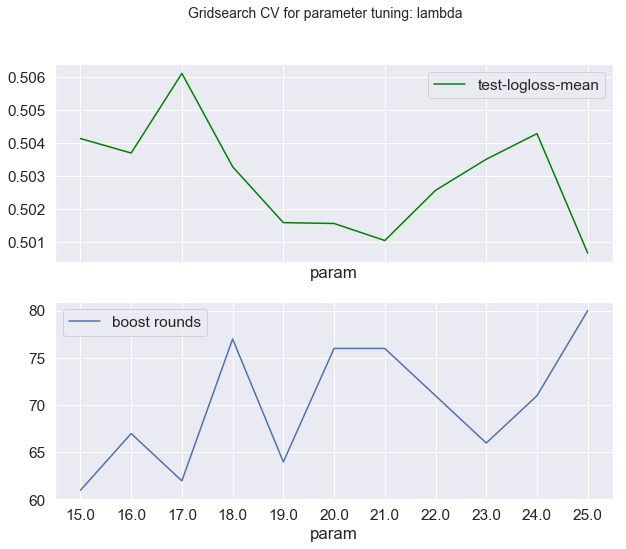

   param  test-logloss-mean  boost rounds
0   15.0           0.504133          61.0
1   16.0           0.503694          67.0
2   17.0           0.506102          62.0
3   18.0           0.503281          77.0
4   19.0           0.501591          64.0
5   20.0           0.501565          76.0
6   21.0           0.501050          76.0
7   22.0           0.502567          71.0
8   23.0           0.503506          66.0
9   24.0           0.504281          71.0
10  25.0           0.500670          80.0


In [25]:
# test values around 20 in step 1
param_test4c_lambda = [i for i in range(15,26,1)]

gridsearch_best_param(param_test4c_lambda, 'lambda', "CV with lambda={}", convert_to_str=True)

lambda = 21 is the optimal one.

In [26]:
# update optimal parameter value
params['lambda'] = 21

#### Step 5: Reduce learning rate

CV with eta=1
Time used: 3.0684072971343994
CV with eta=0.1
Time used: 37.77611780166626
CV with eta=0.05
Time used: 83.04129838943481
CV with eta=0.01
Time used: 186.70483541488647
CV with eta=0.005
Time used: 190.77896928787231


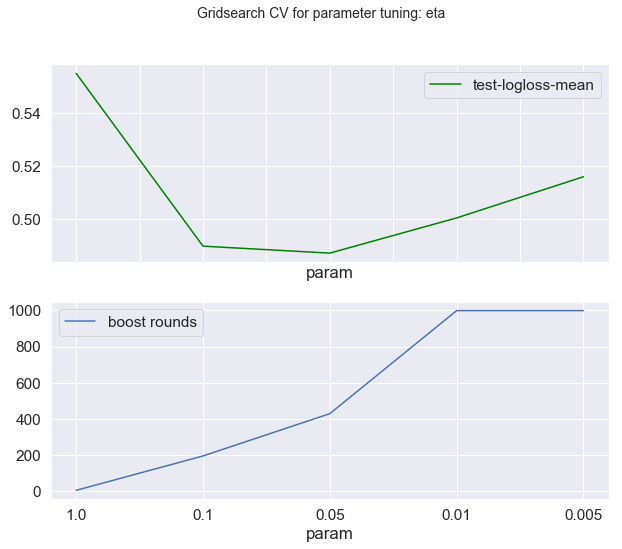

   param  test-logloss-mean  boost rounds
0    1.0           0.554680           5.0
1    0.1           0.490014         195.0
2   0.05           0.487414         429.0
3   0.01           0.500582         999.0
4  0.005           0.515996         999.0
Wall time: 8min 21s


In [27]:
# perform GridSearch on testing 5 values for eta
param_test5 = [1, .1, .05, .01, .005]

# timing
%time gridsearch_best_param(param_test5, 'eta', "CV with eta={}", convert_to_str=True, timed=True)

eta = 0.05 has lowest test-logloss-mean but a high boost rounds (429 rounds). However, it didn't take a long time to run (83 seconds). Hence, we can consider 0.05 as the optimal.

In [27]:
# update best parameter
params['eta'] = 0.05

### Results

In [29]:
# tuned hyperparameters values
params

# compared with default values:
# 'max_depth': 6,
# 'min_child_weight': 1,
# 'eta': 0.3,
# 'subsample': 1,
# 'colsample_bytree': 1,
# 'gamma': 0,
# 'alpha': 0,
# 'lambda': 1,

{'max_depth': 10,
 'min_child_weight': 3,
 'eta': 0.05,
 'subsample': 0.9,
 'colsample_bytree': 1.0,
 'gamma': 0.5,
 'alpha': 0,
 'lambda': 21,
 'scale_pos_weight': 3.5180722891566263,
 'objective': 'binary:logistic',
 'eval_metric': 'logloss'}

In [29]:
# feed in parameters to find optimal 'num_boost_round'
xgb1 = xgb.train(
    params,
    DTrain,
    num_boost_round=NUM_BOOST_ROUND,
    evals=[(DVal, 'valid')],
    early_stopping_rounds=10
)

print("Lowest logloss for validation set: {} with {} rounds".format(xgb1.best_score, xgb1.best_iteration+1))

[0]	valid-logloss:0.68118
Will train until valid-logloss hasn't improved in 10 rounds.
[1]	valid-logloss:0.67011
[2]	valid-logloss:0.66013
[3]	valid-logloss:0.65114
[4]	valid-logloss:0.64255
[5]	valid-logloss:0.63465
[6]	valid-logloss:0.62726
[7]	valid-logloss:0.62047
[8]	valid-logloss:0.61403
[9]	valid-logloss:0.60779
[10]	valid-logloss:0.60232
[11]	valid-logloss:0.59744
[12]	valid-logloss:0.59281
[13]	valid-logloss:0.58825
[14]	valid-logloss:0.58405
[15]	valid-logloss:0.58026
[16]	valid-logloss:0.57657
[17]	valid-logloss:0.57334
[18]	valid-logloss:0.57014
[19]	valid-logloss:0.56678
[20]	valid-logloss:0.56420
[21]	valid-logloss:0.56182
[22]	valid-logloss:0.55961
[23]	valid-logloss:0.55710
[24]	valid-logloss:0.55510
[25]	valid-logloss:0.55301
[26]	valid-logloss:0.55111
[27]	valid-logloss:0.54941
[28]	valid-logloss:0.54762
[29]	valid-logloss:0.54596
[30]	valid-logloss:0.54445
[31]	valid-logloss:0.54318
[32]	valid-logloss:0.54178
[33]	valid-logloss:0.54064
[34]	valid-logloss:0.53957
[35]

[295]	valid-logloss:0.49070
[296]	valid-logloss:0.49059
[297]	valid-logloss:0.49053
[298]	valid-logloss:0.49055
[299]	valid-logloss:0.49046
[300]	valid-logloss:0.49043
[301]	valid-logloss:0.49033
[302]	valid-logloss:0.49015
[303]	valid-logloss:0.49017
[304]	valid-logloss:0.49022
[305]	valid-logloss:0.49023
[306]	valid-logloss:0.49022
[307]	valid-logloss:0.49012
[308]	valid-logloss:0.49003
[309]	valid-logloss:0.48989
[310]	valid-logloss:0.48988
[311]	valid-logloss:0.48997
[312]	valid-logloss:0.48986
[313]	valid-logloss:0.48975
[314]	valid-logloss:0.48963
[315]	valid-logloss:0.48951
[316]	valid-logloss:0.48945
[317]	valid-logloss:0.48941
[318]	valid-logloss:0.48934
[319]	valid-logloss:0.48935
[320]	valid-logloss:0.48935
[321]	valid-logloss:0.48916
[322]	valid-logloss:0.48902
[323]	valid-logloss:0.48905
[324]	valid-logloss:0.48891
[325]	valid-logloss:0.48882
[326]	valid-logloss:0.48865
[327]	valid-logloss:0.48854
[328]	valid-logloss:0.48831
[329]	valid-logloss:0.48828
[330]	valid-logloss:

In [30]:
# remove the early_stopping_rounds since we've got the exact optimal num_boost_round
NUM_BOOST_ROUND = xgb1.best_iteration + 1

optimal_model = xgb.train(
    params,
    DTrain,
    num_boost_round=NUM_BOOST_ROUND,
    evals=[(DVal, 'valid')]
)

[0]	valid-logloss:0.68118
[1]	valid-logloss:0.67011
[2]	valid-logloss:0.66013
[3]	valid-logloss:0.65114
[4]	valid-logloss:0.64255
[5]	valid-logloss:0.63465
[6]	valid-logloss:0.62726
[7]	valid-logloss:0.62047
[8]	valid-logloss:0.61403
[9]	valid-logloss:0.60779
[10]	valid-logloss:0.60232
[11]	valid-logloss:0.59744
[12]	valid-logloss:0.59281
[13]	valid-logloss:0.58825
[14]	valid-logloss:0.58405
[15]	valid-logloss:0.58026
[16]	valid-logloss:0.57657
[17]	valid-logloss:0.57334
[18]	valid-logloss:0.57014
[19]	valid-logloss:0.56678
[20]	valid-logloss:0.56420
[21]	valid-logloss:0.56182
[22]	valid-logloss:0.55961
[23]	valid-logloss:0.55710
[24]	valid-logloss:0.55510
[25]	valid-logloss:0.55301
[26]	valid-logloss:0.55111
[27]	valid-logloss:0.54941
[28]	valid-logloss:0.54762
[29]	valid-logloss:0.54596
[30]	valid-logloss:0.54445
[31]	valid-logloss:0.54318
[32]	valid-logloss:0.54178
[33]	valid-logloss:0.54064
[34]	valid-logloss:0.53957
[35]	valid-logloss:0.53831
[36]	valid-logloss:0.53728
[37]	valid-

[297]	valid-logloss:0.49053
[298]	valid-logloss:0.49055
[299]	valid-logloss:0.49046
[300]	valid-logloss:0.49043
[301]	valid-logloss:0.49033
[302]	valid-logloss:0.49015
[303]	valid-logloss:0.49017
[304]	valid-logloss:0.49022
[305]	valid-logloss:0.49023
[306]	valid-logloss:0.49022
[307]	valid-logloss:0.49012
[308]	valid-logloss:0.49003
[309]	valid-logloss:0.48989
[310]	valid-logloss:0.48988
[311]	valid-logloss:0.48997
[312]	valid-logloss:0.48986
[313]	valid-logloss:0.48975
[314]	valid-logloss:0.48963
[315]	valid-logloss:0.48951
[316]	valid-logloss:0.48945
[317]	valid-logloss:0.48941
[318]	valid-logloss:0.48934
[319]	valid-logloss:0.48935
[320]	valid-logloss:0.48935
[321]	valid-logloss:0.48916
[322]	valid-logloss:0.48902
[323]	valid-logloss:0.48905
[324]	valid-logloss:0.48891
[325]	valid-logloss:0.48882
[326]	valid-logloss:0.48865
[327]	valid-logloss:0.48854
[328]	valid-logloss:0.48831
[329]	valid-logloss:0.48828
[330]	valid-logloss:0.48832
[331]	valid-logloss:0.48824
[332]	valid-logloss:

In [32]:
# save model
optimal_model.save_model(path + 'CreditCardDefault_model_LogisticRegression_XGBoost.model')

### Evaluation

In [ ]:
# load model
# loaded_model = xgb.Booster()
# loaded_model.load_model(path + 'CreditCardDefault_model_LogisticRegression_XGBoost.model')
# predictions_ = loaded_model.predict(DTest)

In [33]:
predictions_ = [int(round(value)) for value in optimal_model.predict(DTest)]

In [34]:
# evaluation - scores
print('accuracy score:', accuracy_score(y_true = ytest, y_pred = predictions_))
print('f1 score:', f1_score(y_true = ytest, y_pred = predictions_))
print('ROC AUC:', roc_auc_score(y_true = ytest, y_score = predictions_))

accuracy score: 0.7958333333333333
f1 score: 0.528664871104271
ROC AUC: 0.7030971874330496


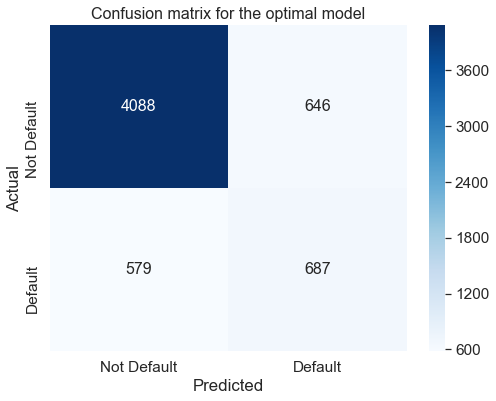

In [36]:
# evaluation - confusion matrix
optimal_cm = pd.DataFrame(confusion_matrix(ytest, predictions_), 
                       columns=['Not Default', 'Default'], index = ['Not Default', 'Default'])
optimal_cm.index.name = 'Actual'
optimal_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,6))
sns.set(font_scale=1.4) # label size
sns.heatmap(optimal_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 16}) # integer format, font size 16
plt.title('Confusion matrix for the optimal model', fontsize=16)
plt.show()

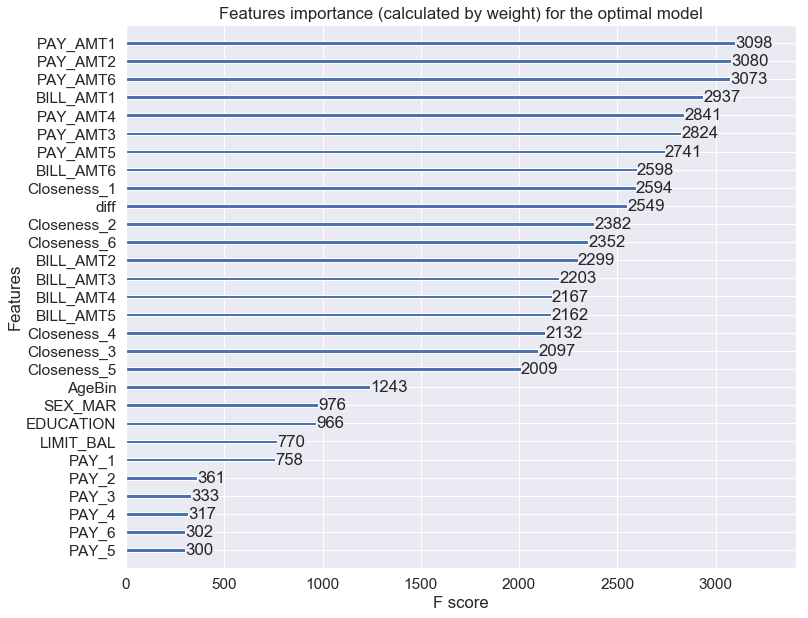

In [37]:
# features importance - by weight
fig, ax = plt.subplots(1,1,figsize=(12,10))
xgb.plot_importance(optimal_model, importance_type='weight', ax=ax)
plt.title('Features importance (calculated by weight) for the optimal model')
plt.show()

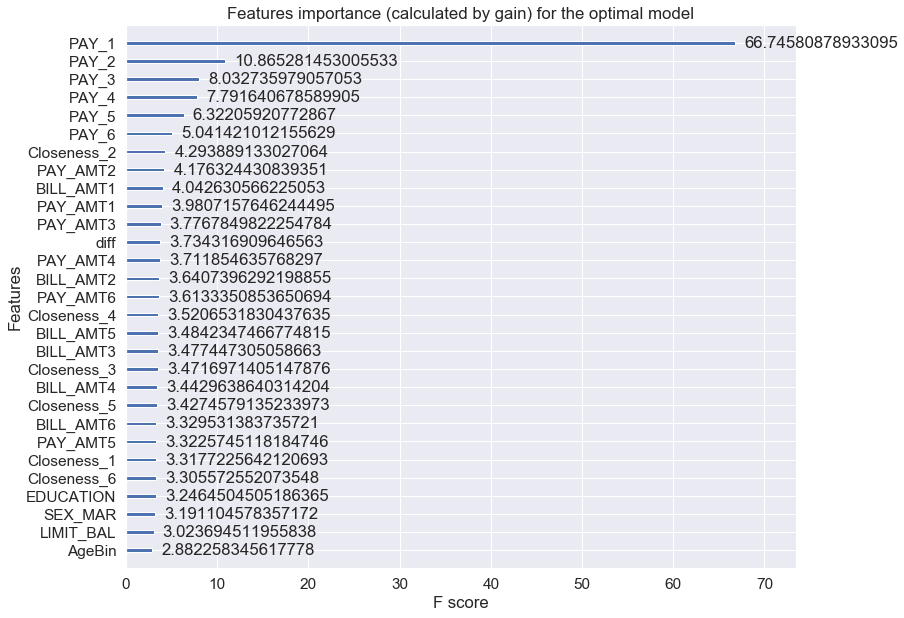

In [38]:
# features importance - by gain
fig, ax = plt.subplots(1,1,figsize=(12,10))
xgb.plot_importance(optimal_model, importance_type='gain', ax=ax)
plt.title('Features importance (calculated by gain) for the optimal model')
plt.show()

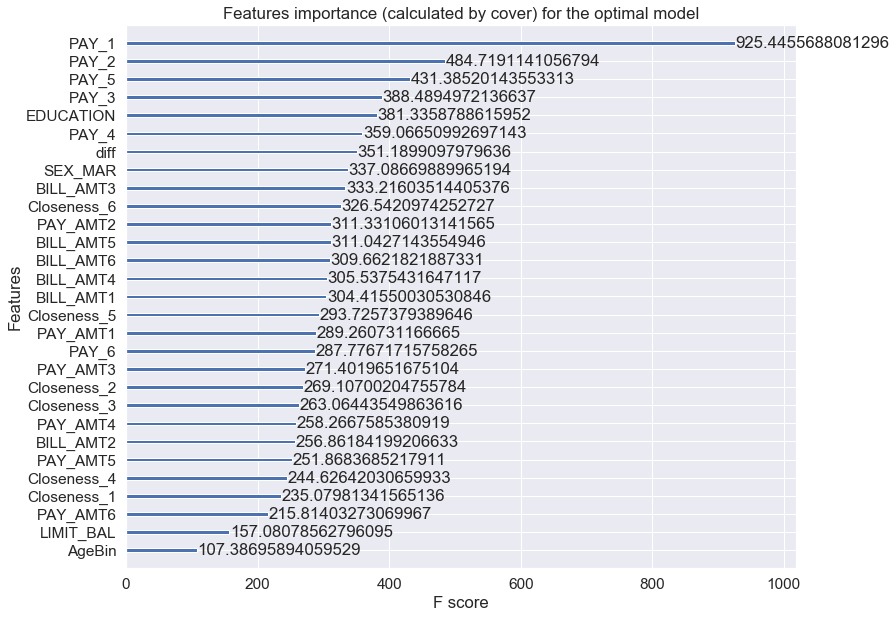

In [39]:
# features importance - by cover
fig, ax = plt.subplots(1,1,figsize=(12,10))
xgb.plot_importance(optimal_model, importance_type='cover', ax=ax)
plt.title('Features importance (calculated by cover) for the optimal model')
plt.show()

Summary of the statistics of the optimal model:
1. **Accuracy score**: 0.796
2. **f1 score**: 0.529
3. **ROC AUC**: 0.703
4. **False Positive**: 646 cases, **False Negative**: 579 cases.
5. The top 3 features appeared most in a tree are PAY_AMT1, PAY_AMT2, PAY_AMT6. The feature has the highest average gain and coverage of splits is PAY_1. 
<br>The 3 features appeared leaest in a tree are PAY_5, PAY_6, PAY_4. The feature has the lowest average gain and coverage of splits is AgeBin.
<br>

Compared to the statistics of the baseline model:
1. The accuracy score is increased by **0.013**
2. The f1 score is increased by **0.007**
3. The ROC AUC is increased by **0.001**
4. False Positive is decreased from 748 cases to 646 cases (by **13.6%**)
<br>False Negative is slightly increased from 555 cases to 579 cases (by **4.3%**).
5. All of the top 3 features appeared most in a tree changed, whereas the 3 features appeared leaest in a tree remained the same.
<br> The feature has the highest average gain & coverage of splits is still *PAY_1* and the feature has the lowest average gain & coverage of splits is still *AgeBin*.
<br>

Overall, we achieved a tiny improvement.

### Feature Selection with XGBoost Feature Importance Scores

In [40]:
# set up an equivalent XGBClassifier model with tuned parameters - XGBoost's scikit-learn API
model = xgb.XGBClassifier(**params, n_estimators=NUM_BOOST_ROUND)
model.fit(Xtrain, ytrain)

predictions = model.predict(Xtest)
accuracy = accuracy_score(ytest, predictions)
print("Accuracy: %.3f%%" % accuracy)

Accuracy: 79.58%


In [114]:
feature_importances = pd.DataFrame(model.feature_importances_, index=model.get_booster().feature_names, columns=['Importance'])
feature_importances

,Importance
LIMIT_BAL,0.016238
EDUCATION,0.017434
SEX_MAR,0.017137
AgeBin,0.015478
PAY_1,0.358438
PAY_2,0.058349
PAY_3,0.043137
PAY_4,0.041843
PAY_5,0.033951
PAY_6,0.027073


In [71]:
thresholds = np.sort(model.feature_importances_)
# create a DataFrame to hold the result
results = pd.DataFrame(columns=['Threshold', 'No. of features', 'Accuracy', 'F1', 'ROC AUC'])

for i in range(len(thresholds)):
    thresh = thresholds[i]
    # select features using threshold
    selection = SelectFromModel(estimator=model, threshold=thresh, prefit=True)
    select_Xtrain = selection.transform(Xtrain)
    # train model
    selection_model = xgb.XGBClassifier(**params, n_estimators=NUM_BOOST_ROUND)
    selection_model.fit(select_Xtrain, ytrain)
    # predict
    select_Xtest = selection.transform(Xtest)
    predictions = selection_model.predict(select_Xtest)
    # eval model
    accuracy = accuracy_score(ytest, predictions)
    f1 = f1_score(ytest, predictions)
    roc_auc = roc_auc_score(ytest, predictions)
    # save results
    results.loc[i, 'Threshold'] = np.round(thresh, 3)
    results.loc[i, 'No. of features'] = select_Xtrain.shape[1]
    results.loc[i, 'Accuracy'] = np.round(accuracy, 3)
    results.loc[i, 'F1'] = np.round(f1, 3)
    results.loc[i, 'ROC AUC'] = np.round(roc_auc, 3)

    print("Thresh=%.3f, n=%d" % (thresh, select_Xtrain.shape[1]))

Thresh=0.015, n=29
Thresh=0.016, n=28
Thresh=0.017, n=27
Thresh=0.017, n=26
Thresh=0.018, n=25
Thresh=0.018, n=24
Thresh=0.018, n=23
Thresh=0.018, n=22
Thresh=0.018, n=21
Thresh=0.018, n=20
Thresh=0.019, n=19
Thresh=0.019, n=18
Thresh=0.019, n=17
Thresh=0.019, n=16
Thresh=0.019, n=15
Thresh=0.020, n=14
Thresh=0.020, n=13
Thresh=0.020, n=12
Thresh=0.020, n=11
Thresh=0.021, n=10
Thresh=0.022, n=9
Thresh=0.022, n=8
Thresh=0.023, n=7
Thresh=0.027, n=6
Thresh=0.034, n=5
Thresh=0.042, n=4
Thresh=0.043, n=3
Thresh=0.058, n=2
Thresh=0.358, n=1


In [87]:
results.sort_values(['No. of features'], inplace=True)
results

,Threshold,No. of features,Accuracy,F1,ROC AUC
28,0.358,1,79.4,51.223,69.094
27,0.058,2,80.217,51.924,69.38
26,0.043,3,79.133,53.038,70.603
25,0.042,4,77.917,53.164,71.134
24,0.034,5,79,53.437,70.982
23,0.027,6,78.783,53.147,70.815
22,0.023,7,77.817,52.345,70.463
21,0.022,8,76.25,51.415,70.136
20,0.022,9,77.333,52.247,70.533
19,0.021,10,77.033,51.852,70.285


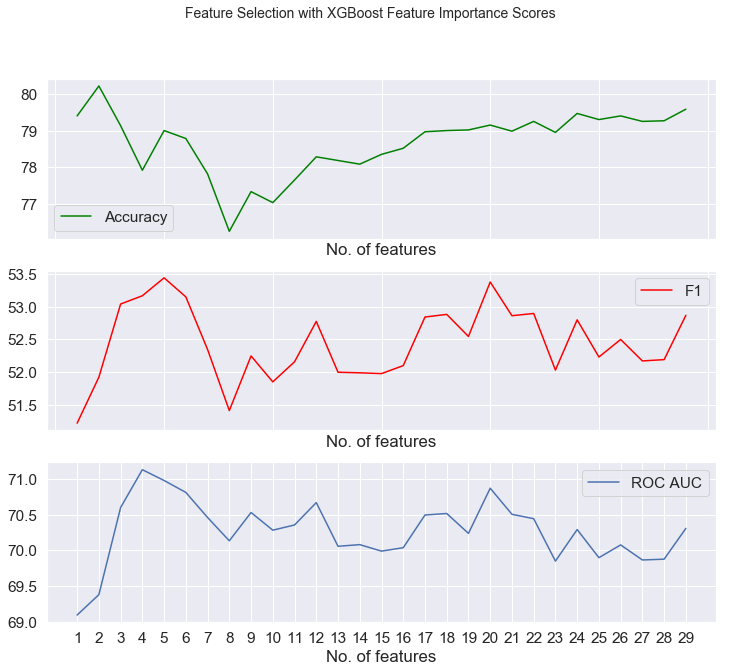

In [102]:
# visualise the results
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,10))
results.plot('No. of features', y=['Accuracy'], ax=ax[0], color='green')
results.plot('No. of features', y=['F1'], ax=ax[1], color='red')
results.plot('No. of features', y=['ROC AUC'], ax=ax[2], x_compat=True)

plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax[1].get_xticklabels(), visible=False)
plt.xticks(np.arange(min(results['No. of features']), max(results['No. of features']+1), 1))
fig.suptitle("Feature Selection with XGBoost Feature Importance Scores", fontsize=14)
plt.show()

Same tendency of change for these three evaluation scores.
<br>**Accuracy**: peaks at [2]
<br>**F1**: peaks at [5, 20]
<br>**ROC AUC**: peaks at [4]

In [110]:
# evaluation scores for the optimal model - regard as the base values for features selection
optimal_accuracy = results.iloc[-1]['Accuracy']
optimal_f1 = results.iloc[-1]['F1']
optimal_roc_auc = results.iloc[-1]['ROC AUC']

In [111]:
# thresholds with accuracy score higher than that of the optimal model
results.loc[(results['Accuracy'] > optimal_accuracy)]

,Threshold,No. of features,Accuracy,F1,ROC AUC
27,0.058,2,80.217,51.924,69.38


In [112]:
# thresholds with f1 score higher than that of the optimal model
results.loc[(results['F1'] > optimal_f1)]

,Threshold,No. of features,Accuracy,F1,ROC AUC
26,0.043,3,79.133,53.038,70.603
25,0.042,4,77.917,53.164,71.134
24,0.034,5,79,53.437,70.982
23,0.027,6,78.783,53.147,70.815
11,0.019,18,79,52.88,70.519
9,0.018,20,79.15,53.373,70.874
7,0.018,22,79.25,52.894,70.446


In [113]:
# thresholds with ROC AUC higher than that of the optimal model
results.loc[(results['ROC AUC'] > optimal_roc_auc)]

,Threshold,No. of features,Accuracy,F1,ROC AUC
26,0.043,3,79.133,53.038,70.603
25,0.042,4,77.917,53.164,71.134
24,0.034,5,79,53.437,70.982
23,0.027,6,78.783,53.147,70.815
22,0.023,7,77.817,52.345,70.463
20,0.022,9,77.333,52.247,70.533
18,0.02,11,77.65,52.158,70.358
17,0.02,12,78.283,52.773,70.672
12,0.019,17,78.967,52.84,70.498
11,0.019,18,79,52.88,70.519


Investigate no. of features = 2, 3, 4, 5.
<br> n = 2: has the highest accuracy score, whereas the F1 and ROC AUC are much lower than the optimal model.
<br> n = 4: has the highest ROC AUC and a relatively high F1 (higher than the optimal model), whereas the accuracy score reaches a local minimum and is much lower than the optimal model.
<br> n = 3, 5: has a relatively high F1 and ROC AUC (higher than the optimal model), whereas the accuracy socre is slightly lower than the optimal model.
<br> **Conclusion**: Either no. of features = **3 or 5** is acceptable. n = 5 is slightly better than n = 3, with higher F1 and ROC AUC but a lower accuracy. We would decide to take a less complex model and accept a modest decrease in estimated accuracy from 79.583% down to 79% (n = 5) or 79.133% (n = 3).

In [158]:
# Get the selected features
def get_selected_features(no_of_features:int):
    df = feature_importances.sort_values(['Importance'], ascending=False)
    return df.iloc[:no_of_features].index.values

In [159]:
print('Selected features for n = 3:', get_selected_features(3))
print('Selected features for n = 5:', get_selected_features(5))

Selected features for n = 3: ['PAY_1' 'PAY_2' 'PAY_3']
Selected features for n = 5: ['PAY_1' 'PAY_2' 'PAY_3' 'PAY_4' 'PAY_5']
